In [46]:
import numpy as np

class Grid:
    """Class defining a one-dimensional Cartesian grid"""
    
    def __init__(self, lx, ly, lz, ncv):
        """Constructor
            lx .... total length of domain in x-direction [m]
            ly .... total length of domain in y-direction [m]
            lz .... total length of domain in z-direction [m]
            ncv ... number of control volumes in domain
        """
        # Store the number of control volumes
        self._ncv = ncv
        
        # Calculate the control volume length
        dx = lx/float(ncv)
        
        # Calculate the face locations
        self._xf = np.array([i*dx for i in range(ncv+1)])
        
        # Calculate the cell centroid locations
        self._xP = np.array([self._xf[0]] + 
                            [0.5*(self._xf[i]+self._xf[i+1]) for i in range(ncv)] +
                            [self._xf[-1]])
        
        # Calculate face areas
        self._Af = ly*lz*np.ones(ncv+1)
        
        # Calculate the outer surface area for each cell
        self._Ao = (2.0*dx*ly + 2.0*dx*lz)*np.ones(ncv)
        
        # Calculate cell volumes
        self._vol = dx*ly*lz*np.ones(ncv)
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
    
    @property
    def xf(self):
        """Face location array"""
        return self._xf
    
    @property
    def xP(self):
        """Cell centroid array"""
        return self._xP
    
    @property
    def dx_WP(self):
        return self.xP[1:-1]-self.xP[0:-2]
        
    @property
    def dx_PE(self):
        return self.xP[2:]-self.xP[1:-1]
      
    @property
    def Af(self):
        """Face area array"""
        return self._Af

    @property
    def Aw(self):
        """West face area array"""
        return self._Af[0:-1]
    
    @property
    def Ae(self):
        """East face area array"""
        return self._Af[1:]
    
    @property
    def Ao(self):
        """Outer face area array"""
        return self._Ao
    
    @property
    def vol(self):
        """Cell volume array"""
        return self._vol

In [47]:
class ScalarCoeffs:
    """Class defining the set of coefficients for a finite-volume discretization
       of a scalar partial differential equation.
    """
    
    def __init__(self, ncv):
        """Constructor
            ncv ... number of control volumes in domain
        """
        self._ncv = ncv
        self._aP = np.zeros(ncv)
        self._aW = np.zeros(ncv)
        self._aE = np.zeros(ncv)
        self._rP = np.zeros(ncv)
        
    def zero(self):
        """Function to zero the coefficient arrays"""
        self._aP.fill(0.0)
        self._aW.fill(0.0)
        self._aE.fill(0.0)
        self._rP.fill(0.0)
        
    def accumulate_aP(self, aP):
        """Function to accumulate values onto aP"""
        self._aP += aP
        
    def accumulate_aW(self, aW):
        """Function to accumulate values onto aW"""
        self._aW += aW

    def accumulate_aE(self, aE):
        """Function to accumulate values onto aE"""
        self._aE += aE
        
    def accumulate_rP(self, rP):
        """Function to accumulate values onto rP"""
        self._rP += rP
        
    @property
    def ncv(self):
        """Number of control volumes in domain"""
        return self._ncv
        
    @property
    def aP(self):
        """Cell coefficient"""
        return self._aP
    
    @property
    def aW(self):
        """West cell coefficient"""
        return self._aW
    
    @property
    def aE(self):
        """East cell coefficient"""
        return self._aE
    
    @property
    def rP(self):
        """Cell residual"""
        return self._rP

In [48]:
from enum import Enum

class BoundaryLocation(Enum):
    """Enumeration class defining boundary condition locations"""
    WEST = 1
    EAST = 2

In [49]:
class RobinBc:
    """Class defining a Neumann boundary condition"""
    
    def __init__(self, phi, grid, ho, k, loc):
        """Constructor
            phi ........ field variable array
            grid ....... grid
            gradient ... gradient at cell adjacent to boundary
            loc ........ boundary location
        """
        self._phi = phi
        self._grid = grid
        self._ho = ho
        self._k = k
        self._loc = loc
        
    def value(self):
        """Return the boundary condition value"""
        if self._loc is BoundaryLocation.WEST:
            return (self._phi[1] + ((self._grid.dx_WP[0]*self._ho*40)/self._k))/(1+((self._grid.dx_WP[0]*self._ho)/self._k))
        elif self._loc is BoundaryLocation.EAST:
            return (self._phi[-2] + ((self._grid.dx_PE[-1]*self._ho*50)/self._k))/(1+((self._grid.dx_PE[-1]*self._ho)/self._k))
        else:
            raise ValueError("Unknown boundary location")
    
    def coeff(self):
        """Return the linearization coefficient"""
        if self._loc is BoundaryLocation.WEST:
            return 1 / (1+((self._grid.dx_WP[0]*self._ho)/self._k))
        elif self._loc is BoundaryLocation.EAST:
            return 1 / (1+((self._grid.dx_PE[-1]*self._ho)/self._k))
        else:
            raise ValueError("Unknown boundary location")
            
    def apply(self):
        """Applies the boundary condition in the referenced field variable array"""
        if self._loc is BoundaryLocation.WEST:
            self._phi[0] = (self._phi[1] + ((self._grid.dx_WP[0]*self._ho*40)/self._k))/(1+((self._grid.dx_WP[0]*self._ho)/self._k))
        elif self._loc is BoundaryLocation.EAST:
            self._phi[-1] = (self._phi[-2] + ((self._grid.dx_PE[-1]*self._ho*50)/self._k))/(1+((self._grid.dx_PE[-1]*self._ho)/self._k))
        else:
            raise ValueError("Unknown boundary location")

In [50]:
class DiffusionModel:
    """Class defining a diffusion model"""
    
    def __init__(self, grid, phi, gamma, west_bc, east_bc):
        """Constructor"""
        self._grid = grid
        self._phi = phi
        self._gamma = gamma
        self._west_bc = west_bc
        self._east_bc = east_bc
        
    def add(self, coeffs):
        """Function to add diffusion terms to coefficient arrays"""
        
        # Calculate the west and east face diffusion flux terms for each face
        flux_w = - self._gamma*self._grid.Aw*(self._phi[1:-1]-self._phi[0:-2])/self._grid.dx_WP
        flux_e = - self._gamma*self._grid.Ae*(self._phi[2:]-self._phi[1:-1])/self._grid.dx_PE
        
        # Calculate the linearization coefficients
        coeffW = - self._gamma*self._grid.Aw/self._grid.dx_WP
        coeffE = - self._gamma*self._grid.Ae/self._grid.dx_PE
        coeffP = - coeffW - coeffE
        
        # Modify the linearization coefficients on the boundaries
        coeffP[0] += coeffW[0]*self._west_bc.coeff()
        coeffP[-1] += coeffE[-1]*self._east_bc.coeff()
        
        # Zero the boundary coefficients that are not used
        coeffW[0] = 0.0
        coeffE[-1] = 0.0
        
        # Calculate the net flux from each cell
        flux = flux_e - flux_w
        
        # Add to coefficient arrays
        coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_aW(coeffW)
        coeffs.accumulate_aE(coeffE)
        coeffs.accumulate_rP(flux)
        
        # Return the modified coefficient array
        return coeffs

In [51]:
class SurfaceConvectionModel:
    """Class defining a surface convection model"""
    
    def __init__(self, grid):
        """Constructor"""
        self._grid = grid
        #self._T = T
        #self._ho = ho
        #self._To = To
        
    def add(self, coeffs):
        """Function to add surface convection terms to coefficient arrays"""
        
        # Calculate the source term
        source = -50000*self._grid.vol
        
        # Calculate the linearization coefficients
        #coeffP = 
        
        # Add to coefficient arrays
        #coeffs.accumulate_aP(coeffP)
        coeffs.accumulate_rP(source)
        
        return coeffs

In [52]:
from scipy.sparse.linalg import spsolve
from scipy.sparse import csr_matrix

def get_sparse_matrix(coeffs):
    """Function to return a sparse matrix representation of a set of scalar coefficients"""
    ncv = coeffs.ncv
    data = np.zeros(3*ncv-2)
    rows = np.zeros(3*ncv-2, dtype=int)
    cols = np.zeros(3*ncv-2, dtype=int)
    data[0] = coeffs.aP[0]
    data[1] = coeffs.aE[0]
    rows[0] = 0
    cols[0] = 0
    rows[1] = 0
    cols[1] = 1
    for i in range(ncv-2):
        data[3*i+2] = coeffs.aW[i+1]
        data[3*i+3] = coeffs.aP[i+1]
        data[3*i+4] = coeffs.aE[i+1]
        rows[3*i+2:3*i+5] = i+1
        cols[3*i+2] = i
        cols[3*i+3] = i+1
        cols[3*i+4] = i+2
    data[3*ncv-4] = coeffs.aW[-1]
    data[3*ncv-3] = coeffs.aP[-1]
    rows[3*ncv-4:3*ncv-2] = ncv-1
    cols[3*ncv-4] = ncv-2
    cols[3*ncv-3] = ncv-1
    return csr_matrix((data, (rows, cols)))

def solve(coeffs):
    """Function to solve the linear system and return the correction field"""
    # Get the sparse matrix
    A = get_sparse_matrix(coeffs)
    # Solve the linear system
    return spsolve(A, -coeffs.rP)

In [53]:
def problem3(ncv):    
    import numpy as np
    from numpy.linalg import norm

    # Define the grid
    #lx = 0.1
    #ly = 0.1
    #lz = 0.1
    #ncv = 10
    #grid = Grid(lx, ly, lz, ncv)

    # Set the maximum number of iterations and convergence criterion
    maxIter = 1000
    converged = 1e-6

    # Define thermophysical properties
    k = 26

    # Define convection parameters
    ho = 280
    To = 60

    # Define the coefficients
    coeffs = ScalarCoeffs(grid.ncv)

    # Initial conditions
    T0 = 300

    # Initialize field variable arrays
    T = T0*np.ones(grid.ncv+2)

    # Define boundary conditions
    west_bc = RobinBc(T, grid, ho, k, BoundaryLocation.WEST)
    east_bc = RobinBc(T, grid, ho, k,  BoundaryLocation.EAST)

    # Apply boundary conditions
    west_bc.apply()
    east_bc.apply()

    # Define the diffusion model
    diffusion = DiffusionModel(grid, T, k, west_bc, east_bc)

    # Define the surface convection model
    surfaceConvection = SurfaceConvectionModel(grid)

    # Iterate until the solution is converged
    for i in range(maxIter):
        # Zero the coefficients and add each influence
        coeffs.zero()
        coeffs = diffusion.add(coeffs)
        coeffs = surfaceConvection.add(coeffs)

        # Compute residual and check for convergence 
        maxResid = norm(coeffs.rP, np.inf)
        avgResid = np.mean(np.absolute(coeffs.rP))
        print("Iteration = {}; Max. Resid. = {}; Avg. Resid. = {}".format(i, maxResid, avgResid))
        if maxResid < converged:
            break

        # Solve the sparse matrix system
        dT = solve(coeffs)

        # Update the solution and boundary conditions
        T[1:-1] += dT
        west_bc.apply()
        east_bc.apply()
    return T
    
#print(grid.vol)
#print(grid.Ao)

In [54]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
ncv=5
lx = 0.1
ly = 0.005
lz = 0.005
xPosition=[]
Temp=[]

for i in range(3):
    ncv+=i
    grid = Grid(lx, ly, lz, ncv)
    xPosition.append(grid.xP)
    Temp.append(problem3(ncv))

Iteration = 0; Max. Resid. = 1.6180555555555554; Avg. Resid. = 0.6495833333333328
Iteration = 1; Max. Resid. = 3.7921055184853e-15; Avg. Resid. = 1.1303458169464875e-15
Iteration = 0; Max. Resid. = 1.6492843137254878; Avg. Resid. = 0.5529444444444438
Iteration = 1; Max. Resid. = 3.3410774147313305e-15; Avg. Resid. = 1.3970306393199887e-15
Iteration = 0; Max. Resid. = 1.6896002252252282; Avg. Resid. = 0.4259206081081083
Iteration = 1; Max. Resid. = 2.7200464103316335e-15; Avg. Resid. = 1.3374717999781183e-15


In [55]:
import numpy as np
print(xPosition)
print(Temp)

[array([0.  , 0.01, 0.03, 0.05, 0.07, 0.09, 0.1 ]), array([0.        , 0.00833333, 0.025     , 0.04166667, 0.05833333,
       0.075     , 0.09166667, 0.1       ]), array([0.     , 0.00625, 0.01875, 0.03125, 0.04375, 0.05625, 0.06875,
       0.08125, 0.09375, 0.1    ])]
[array([52.17857143, 53.49010989, 55.34395604, 56.42857143, 56.74395604,
       56.29010989, 55.67857143]), array([52.17857143, 53.27152015, 54.92322955, 56.04075092, 56.62408425,
       56.67322955, 56.18818681, 55.67857143]), array([52.17857143, 52.99828297, 54.33722527, 55.37568681, 56.11366758,
       56.55116758, 56.68818681, 56.52472527, 56.06078297, 55.67857143])]


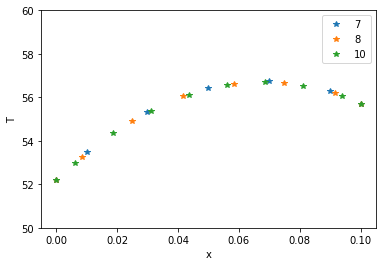

In [56]:
%matplotlib inline
import matplotlib.pyplot as plt

i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, '*', label=str(len(xPosition[i])))
    i=i+1

plt.xlabel("x")
plt.ylabel("T")
plt.ylim(50,60)
plt.legend()
plt.show()

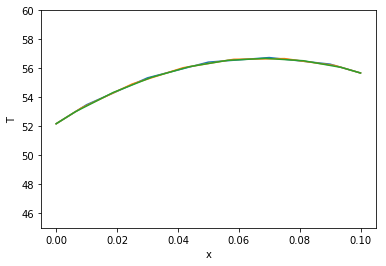

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
i = 0
for x, T in zip(xPosition, Temp):
    plt.plot(x, T, label=str(i))
    i += 1
#plt.plot(grid.xP, T)
plt.xlabel("x")
plt.ylabel("T")
plt.ylim(45,60)
plt.show()